In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from scipy.stats import multivariate_normal, mode
from tqdm.notebook import trange, tqdm
from matplotlib import colormaps

np.random.seed(42)

In [3]:
# Gaussian Mixture Model Parameters
# Pis
pi = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Means
means = [
    [-10.0, 0.0],
    [0.0, -10.0],
    [10.0, 0.0],
    [0.0, 10.0],
    [-5.0, 4.5],
    [5.0, 4.5],
    [0.0, -0.5],
    [0.0, -7.5],
    [-7.0, -5.5],
    [7.0, -5.5],
]

# Sigmas
covs = [
    [[0.1, 0.0], [0.0, 15.0]],
    [[15.0, 0.0], [0.0, 0.1]],
    [[0.1, 0.0], [0.0, 15.0]],
    [[15.0, 0.0], [0.0, 0.1]],
    [[3.0, 0.0], [0.0, 0.1]],
    [[1.0, 0.0], [0.0, 1.0]],
    [[0.1, 0.0], [0.0, 3.0]],
    [[4.0, 0.0], [0.0, 0.1]],
    [[0.5500000000000002, -0.45], [-0.45, 0.5499999999999999]],
    [[0.5500000000000002, 0.45], [0.45, 0.5499999999999999]],
]

In [4]:
# Generate synthetic data from the GMM
def generate_data(n_samples=1000):
    data = []
    labels = []
    for i, (mean, cov) in enumerate(zip(means, covs)):
        n = int(n_samples * pi[i])
        samples = np.random.multivariate_normal(mean, cov, n)
        data.append(samples)
        labels.extend([i] * n)
    return np.vstack(data), np.array(labels)


data, labels = generate_data()

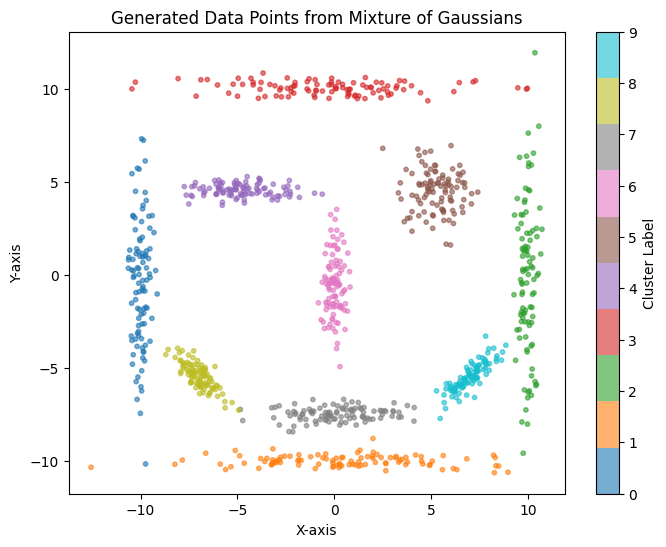

In [8]:
# Visualize the true distribution
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.6, c=labels, cmap="tab10", s=10)
plt.title("Generated Data Points from Mixture of Gaussians")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.colorbar(label="Cluster Label")
#plt.savefig("True_Distribution.png")
plt.show()

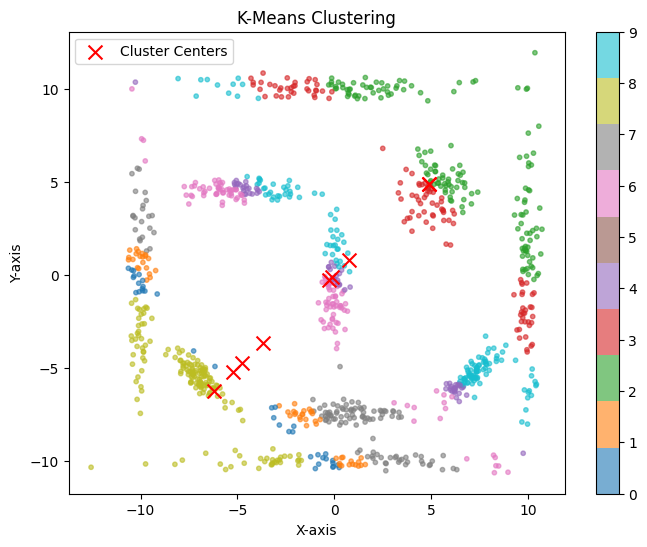

[[-5.21840982 -5.21840982]
 [-4.74477141 -4.74477141]
 [ 4.89282001  4.89282001]
 [ 4.86682148  4.86682148]
 [-0.11965113 -0.11965113]
 [ 4.88363302  4.88363302]
 [-0.26800563 -0.26800563]
 [-3.66848384 -3.66848384]
 [-6.20762663 -6.20762663]
 [ 0.7742464   0.7742464 ]]


In [17]:
# 1. K-Means Clustering
def run_kmeans(data, n_clusters=3, max_iterations=1000):
    # Initialize predictions and centers  
    predictions = np.random.randint(0, n_clusters, size=len(data))
    centers = np.random.rand(n_clusters, data.shape[1])

    # K-means for max iterations or when the centers does not change
    for it in range(max_iterations):

        # Step 1: Predictions
        distances = np.zeros((data.shape[0], n_clusters))
        for c in range(n_clusters):
            distances[:, c] = np.linalg.norm(data - centers[c], axis=1)
        predictions = np.argmin(distances, axis=1)

        # Step 2: Updating cluster center
        new_centers = np.zeros((n_clusters, data.shape[1]))
        for c in range(n_clusters):
            new_centers[c,:] = np.mean(data[labels==c])

        # Break if center don't change 
        # if np.all(centers == new_centers):
        #     print(f"Converged after {it} iterations")
        #     break

        centers = new_centers
    return predictions, centers

n_clusters = len(pi)
kmeans_predictions, centers = run_kmeans(data, n_clusters)

# Create a colormap for the clusters
cmap = colormaps["tab10"].resampled(n_clusters)

# Plot K-Means Results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    data[:, 0],
    data[:, 1],
    c=kmeans_predictions,
    cmap=cmap,
    alpha=0.6,
    s=10,
)

plt.scatter(
    centers[:, 0], 
    centers[:, 1], 
    c="red", 
    marker="x", 
    s=100, 
    label="Cluster Centers"
)

# Add a color bar
cbar = plt.colorbar(scatter, ticks=range(n_clusters))
cbar.ax.set_yticklabels([f"{i}" for i in range(n_clusters)])  # Label clusters

# Add labels, legend, and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("K-Means Clustering")
plt.legend()
#plt.savefig("K-means_clustering")
plt.show()
print(centers)

In [93]:
# Helper function for gibbs and Metropolis Hastings

def compute_posterior(data, mixing_coeff, mean, covariance):
    liklihood = multivariate_normal.pdf(data, mean, covariance)
    return mixing_coeff*liklihood 

def update_cluster_prop(data, cluster_assignments, mixing_coeff, means, covariances):
    for k in range(n_clusters):
                    n_points, dim = data.shape
                    points_in_cluster_k = data[cluster_assignments==k]
                    means[k] = np.mean(points_in_cluster_k, axis=0)
                    mixing_coeff[k] = len(points_in_cluster_k)/n_points
                    covariances[k] = np.matmul((points_in_cluster_k - means[k]).T, (points_in_cluster_k - means[k]))/len(points_in_cluster_k)
                    epsilon = 1e-6 
                    covariances[k] += epsilon * np.eye(dim)
    return mixing_coeff, means, covariances

  0%|          | 0/700 [00:00<?, ?it/s]

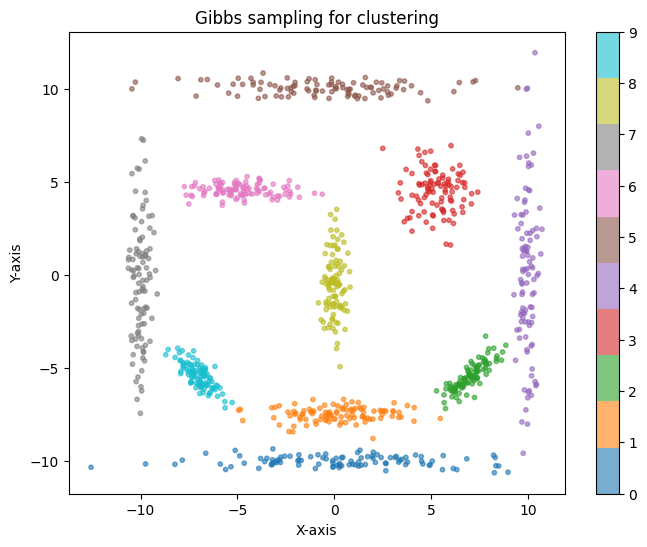

In [96]:
# # 2. Gibbs Sampling for Clustering
    
def gibbs_sampling(data, n_clusters=3, n_samples=500, burn_in=200):
     n_points, dim = data.shape
     cluster_assignments = np.random.choice(n_clusters, n_points)
    

     # Initilize clusters
     means = data[np.random.choice(n_points, n_clusters, replace=False)]
     covariances = np.array([np.eye(dim)] * n_clusters)
     mixing_coeff = np.ones(n_clusters) / n_clusters

     # Gibbs sampling for clustering 
     samples_to_save = np.zeros((n_samples, n_points), dtype=np.int64)
     for sample in trange(n_samples+burn_in):
         for i in range(n_points):
             posterior_probs = list()
             
             for k in range(n_clusters):
                 
                 # Calculating posterior up to a normalization constant 
                 posterior_probs.append(compute_posterior(data[i,:], mixing_coeff[k], means[k], covariances[k]))
                 
             # Assign the point to a cluster with the calculated Posterior probability
             cluster_assignments[i] = np.random.choice(n_clusters,  p=posterior_probs/sum(posterior_probs))

         mixing_coeff, means, covariances = update_cluster_prop(data, cluster_assignments, mixing_coeff, means, covariances)

         if sample >= burn_in:
             samples_to_save[sample - burn_in] = cluster_assignments
             
     return mode(samples_to_save, axis=0)[0]

n_clusters = len(pi)
gibbs_predictions = gibbs_sampling(data, n_clusters)

cmap = colormaps["tab10"].resampled(n_clusters)

# Plot the scatter points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    data[:, 0],
    data[:, 1],
    c=gibbs_predictions,
    cmap=cmap,
    alpha=0.6,
    s=10,
)

# Add a color bar
cbar = plt.colorbar(scatter, ticks=range(n_clusters))
cbar.ax.set_yticklabels([f"{i}" for i in range(n_clusters)])  # Label clusters

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Gibbs sampling for clustering")
#plt.savefig("Gibbs_Sampling_for_clustering.png")
plt.show()

  0%|          | 0/700 [00:00<?, ?it/s]

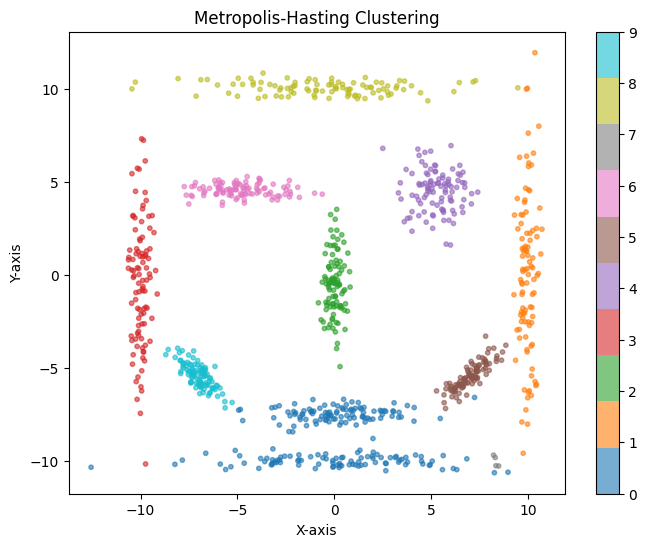

In [129]:
# 3. Metropolis-Hastings for Clustering
    
def metropolis_hastings(
    data, n_clusters=3, proposal_var=0.1, n_samples=500, burn_in=200
):
    # Initilize assignments 
    n_points, dim = data.shape
    cluster_assignments = np.random.choice(n_clusters, n_points)

    # Initilize clusters
    means = data[np.random.choice(n_points, n_clusters, replace=False)]
    covariances = np.array([np.eye(dim)] * n_clusters)
    mixing_coeff = np.ones(n_clusters) / n_clusters
    
    samples_to_save = np.zeros((n_samples, n_points), dtype=np.int64)
    for sample in trange(n_samples+burn_in):
        for i in range(n_points):
            
            z = cluster_assignments[i]
            z_prime = np.random.choice(n_clusters)
            old_posterior = compute_posterior(data[i,:], mixing_coeff[z], means[z], covariances[z])
            new_posterior = compute_posterior(data[i,:], mixing_coeff[z_prime], means[z_prime], covariances[z_prime])
            
            alfa = min(1, new_posterior/old_posterior)
            
            if np.random.uniform(0,1) < alfa:
                cluster_assignments[i] = z_prime
            else:
                cluster_assignments[i] = z
                
        mixing_coeff, means, covariances = update_cluster_prop(data, cluster_assignments, mixing_coeff, means, covariances)
            
        if sample >= burn_in:
             samples_to_save[sample - burn_in] = cluster_assignments

    return mode(samples_to_save, axis=0)[0]

n_clusters = len(pi)
mh_predictions = metropolis_hastings(data, n_clusters)

cmap = colormaps["tab10"].resampled(n_clusters)

# Plot the scatter points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    data[:, 0],
    data[:, 1],
    c=mh_predictions,
    cmap=cmap,
    alpha=0.6,
    s=10,
)

# Add a color bar
cbar = plt.colorbar(scatter, ticks=range(n_clusters))
cbar.ax.set_yticklabels([f"{i}" for i in range(n_clusters)])  # Label clusters

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Metropolis-Hasting Clustering")
#plt.savefig("Gibbs_Sampling_for_clustering.png")
plt.show()

In [130]:
# Evaluate Clustering Results

# Assuming true_labels is a numpy array containing the true labels of the data points
# and kmeans_predictions, gibbs_predictions, mh_predictions are the predicted labels

# Calculate ARI for each clustering method
kmeans_ari = adjusted_rand_score(labels, kmeans_predictions)
gibbs_ari = adjusted_rand_score(labels, gibbs_predictions)
mh_ari = adjusted_rand_score(labels, mh_predictions)

# Print the ARI results
print("Adjusted Rand Index of Clustering Methods:")
print(f"K-Means ARI: {kmeans_ari:.2f}")
print(f"Gibbs Sampling ARI: {gibbs_ari:.2f}")
print(f"Metropolis-Hastings ARI: {mh_ari:.2f}")


Adjusted Rand Index of Clustering Methods:
K-Means ARI: 0.32
Gibbs Sampling ARI: 0.99
Metropolis-Hastings ARI: 0.88


In [131]:
# Compare Results
print("Comparison of Clustering Results:")
print("K-Means Predictions:", np.bincount(kmeans_predictions))
print("Gibbs Sampling Predictions:", np.bincount(gibbs_predictions))
print("Metropolis-Hastings Predictions:", np.bincount(mh_predictions))

Comparison of Clustering Results:
K-Means Predictions: [ 37  57 156 115  67   1 126 122 171 148]
Metropolis-Hastings Predictions: [199 102 100 100 100  98 100   4  98  99]
